In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
gdf = pd.read_parquet("../data/processed/eda2.parquet")

In [4]:
threshold = 10000

(gdf["price"]>threshold).sum()/len(gdf)

0.04620991741063965

In [5]:
gdf = gdf[gdf["price"]<threshold]

In [6]:
# Quick patch for letType and furnishType

gdf["letType"] = gdf["letType"].fillna("not_specified")
gdf["furnishType"] = gdf["furnishType"].fillna("uknown")

### Split dataset geographicaly 

In [7]:
seed = 42 # Fix seed for reproducibility of the splt

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, test_index in stratified_split.split(gdf, gdf['borough']):
    train_df = gdf.iloc[train_index]
    test_df = gdf.iloc[test_index]

In [8]:
embeds_train = []
embeds_test = []

for row in train_df["embeddings"]:
    embeds_train.append(row)
    
for row in test_df["embeddings"]:
    embeds_test.append(row) 
    
    
Xe_train = np.array(embeds_train)
Xe_test = np.array(embeds_test)

### Train Model

In [11]:
numerical_features = ["latitude", "longitude","distance_to_center","angle_from_center","distance_to_station1","distance_to_station2","distance_to_station3"]
categorical_features = ["bedrooms","bathrooms","deposit","zone","borough","propertyType","furnishType","NoiseClass","letType", "TFL1", "TFL2", "TFL3", "RAIL1", "RAIL2","RAIL3"]
 
features = numerical_features+categorical_features
target = "price"


model = CatBoostRegressor(cat_features=categorical_features)
model.fit(train_df[features],train_df[target])

Learning rate set to 0.067097
0:	learn: 1701.1794427	total: 71.3ms	remaining: 1m 11s
1:	learn: 1636.2356389	total: 89.3ms	remaining: 44.5s
2:	learn: 1576.5087021	total: 98.6ms	remaining: 32.8s
3:	learn: 1523.7128639	total: 108ms	remaining: 26.8s
4:	learn: 1473.7194283	total: 112ms	remaining: 22.4s
5:	learn: 1428.8259223	total: 116ms	remaining: 19.2s
6:	learn: 1388.0219177	total: 120ms	remaining: 17s
7:	learn: 1351.3150172	total: 124ms	remaining: 15.4s
8:	learn: 1315.8272519	total: 128ms	remaining: 14s
9:	learn: 1284.2801912	total: 130ms	remaining: 12.9s
10:	learn: 1253.9195245	total: 134ms	remaining: 12.1s
11:	learn: 1227.1969954	total: 139ms	remaining: 11.4s
12:	learn: 1202.7799369	total: 142ms	remaining: 10.7s
13:	learn: 1180.4560814	total: 146ms	remaining: 10.2s
14:	learn: 1161.2878080	total: 148ms	remaining: 9.73s
15:	learn: 1143.5769210	total: 152ms	remaining: 9.34s
16:	learn: 1126.3894280	total: 156ms	remaining: 8.99s
17:	learn: 1110.4366478	total: 159ms	remaining: 8.68s
18:	lear

In [15]:
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    "iterations": np.random.randint(500, 2000, 10),  # Number of trees
    "learning_rate": np.random.uniform(0.01, 0.3, 10),  # Step size
    "depth": np.random.randint(4, 12, 10),  # Tree depth
    "l2_leaf_reg": np.random.uniform(0.01, 10, 10),  # L2 regularization
    "bagging_temperature": np.random.uniform(0.0, 1.0, 10),  # Subsampling randomness
}

# Initialize CatBoostRegressor
model = CatBoostRegressor(cat_features=categorical_features, loss_function="RMSE", verbose=0)




In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_dist, 
    n_iter=20,  # Number of random samples
    scoring="neg_root_mean_squared_error",  
    cv=5,  # 3-Fold CV for speed
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Run the search
random_search.fit(train_df[features], train_df[target])

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'learning_rate': 0.11760324310356311, 'l2_leaf_reg': 0.2904223781160849, 'iterations': 1203, 'depth': 7, 'bagging_temperature': 0.2012555737904892}


In [17]:
best_model = CatBoostRegressor(**best_params, cat_features=categorical_features)
best_model.fit(train_df[features], train_df[target])


0:	learn: 1641.6497181	total: 7.45ms	remaining: 8.96s
1:	learn: 1531.3165794	total: 12.8ms	remaining: 7.71s
2:	learn: 1438.7897138	total: 19.6ms	remaining: 7.83s
3:	learn: 1361.5398873	total: 24.5ms	remaining: 7.35s
4:	learn: 1297.7523095	total: 28.7ms	remaining: 6.89s
5:	learn: 1244.8690337	total: 33.5ms	remaining: 6.68s
6:	learn: 1197.1291185	total: 39.1ms	remaining: 6.67s
7:	learn: 1157.4021061	total: 43.4ms	remaining: 6.49s
8:	learn: 1122.9308984	total: 47.1ms	remaining: 6.25s
9:	learn: 1095.0570604	total: 51.1ms	remaining: 6.09s
10:	learn: 1071.4827447	total: 54.9ms	remaining: 5.95s
11:	learn: 1049.9263492	total: 59.4ms	remaining: 5.9s
12:	learn: 1030.3605232	total: 64ms	remaining: 5.86s
13:	learn: 1013.7475042	total: 69.5ms	remaining: 5.9s
14:	learn: 999.0972370	total: 74.5ms	remaining: 5.9s
15:	learn: 986.8870231	total: 79.2ms	remaining: 5.87s
16:	learn: 976.2514509	total: 84.3ms	remaining: 5.88s
17:	learn: 966.9557293	total: 89.4ms	remaining: 5.89s
18:	learn: 958.7895551	total:

In [18]:
y_test_pred = best_model.predict(test_df[features])

y_true = test_df[target].values
y_pred = y_test_pred

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 13.84%
MAE: 432.12
R²: 0.85


Text(0, 0.5, 'Predicted')

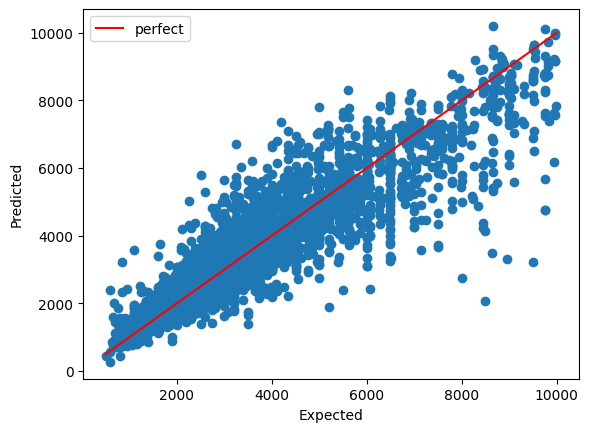

In [19]:
plt.scatter(test_df[target].values,y_test_pred)
plt.plot(np.linspace(500,10000,10),np.linspace(500,10000,10),c="red",label="perfect")
plt.legend()
plt.xlabel("Expected")
plt.ylabel("Predicted")

### Calculate errors in predictions 

In [12]:
y_test_pred = model.predict(test_df[features])

y_true = test_df[target].values
y_pred = y_test_pred

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 14.91%
MAE: 468.47
R²: 0.83


In [10]:
y_test_pred = model.predict(test_df[features])

y_true = test_df[target].values
y_pred = y_test_pred

mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

MAPE: 14.91%
MAE: 468.47
R²: 0.83


Text(0, 0.5, 'Predicted')

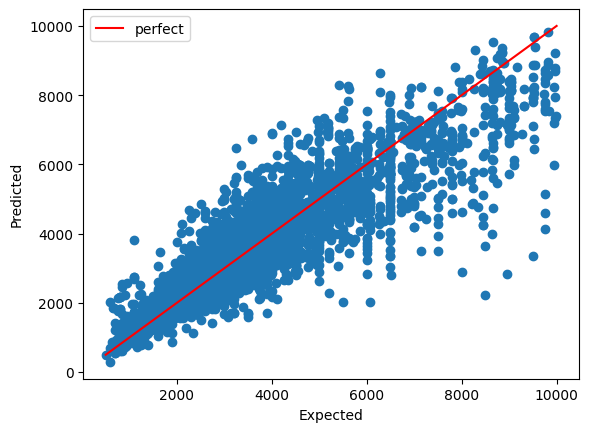

In [11]:
plt.scatter(test_df[target].values,y_test_pred)
plt.plot(np.linspace(500,10000,10),np.linspace(500,10000,10),c="red",label="perfect")
plt.legend()
plt.xlabel("Expected")
plt.ylabel("Predicted")

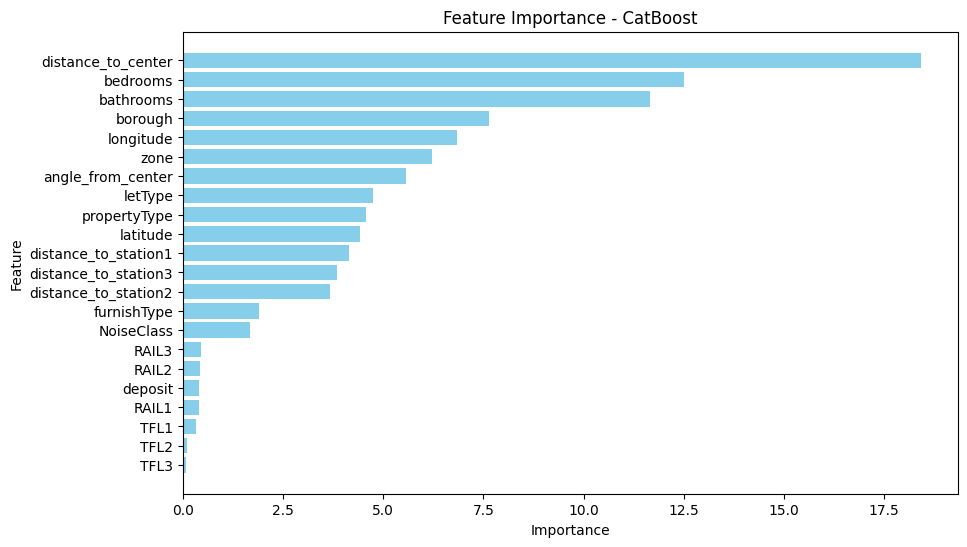

In [20]:
feature_importances = best_model.get_feature_importance()
feature_names = best_model.feature_names_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoost')
plt.gca().invert_yaxis()  
plt.show()

The model is biased for super expensive properties

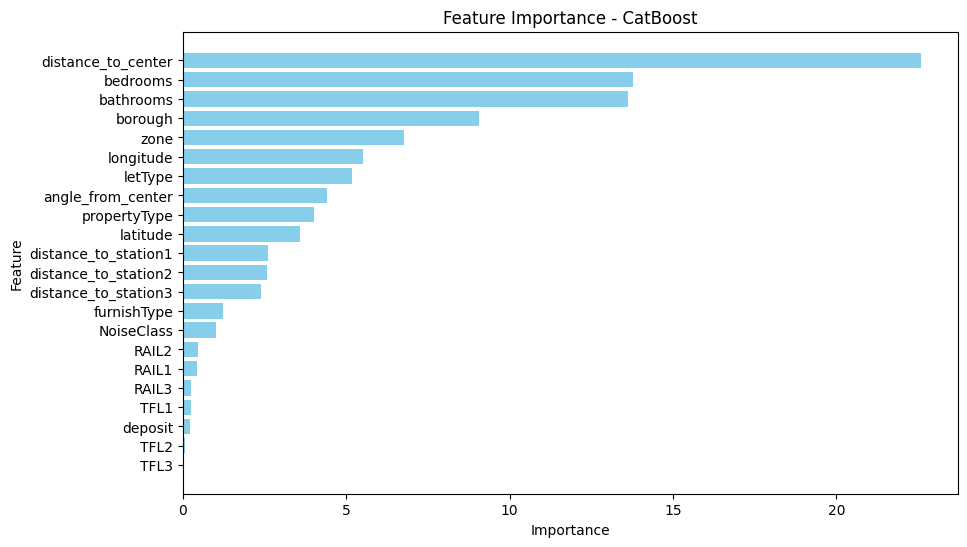

In [12]:
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoost')
plt.gca().invert_yaxis()  
plt.show()